In [1]:
#importing require python packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from keras.models import model_from_json
import pickle
from sklearn.model_selection import train_test_split
from keras.applications import InceptionResNetV2 #loading inception algorithm
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.applications import DenseNet201 #loading densenet
from keras.applications import Xception #laoding xceptionnet
from keras.applications import MobileNetV2#loading MobileNetV2
from keras.applications.nasnet import NASNetLarge #Loading NasNet
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import timeit
from keras.models import Sequential, Model

Using TensorFlow backend.
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#finding class labels available in dataset
path = 'Dataset'
labels = []
X = []
Y = []
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index        
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name)
print("Class labels found in dataset : "+str(labels))

Class labels found in dataset : ['COVID-19', 'Normal', 'TB']



Images normalization & Shuffling task completed
Total images found in dataset : 1023


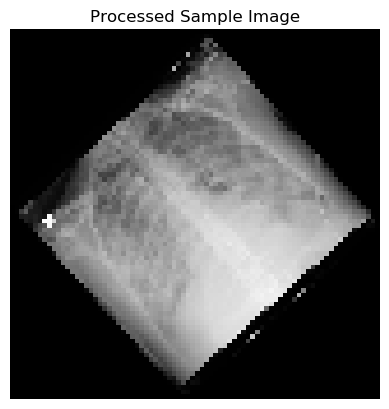

In [3]:
#now loading dataset images
if os.path.exists('models/X.txt.npy'):#if dataset images already processed then load it
    X = np.load('models/X.txt.npy')
    Y = np.load('models/Y.txt.npy')
else:
    for root, dirs, directory in os.walk(path):#if not processed then loop all images
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j]) #read images
                img = cv2.resize(img, (80,80)) #resize image
                im2arr = np.array(img)
                im2arr = im2arr.reshape(80,80,3)
                X.append(im2arr)#add image features to X array
                label = getID(name) #get label for the image
                Y.append(label)
    X = np.asarray(X) #convert array to numpy format
    Y = np.asarray(Y)
    np.save('models/X.txt',X)#save processed images
    np.save('models/Y.txt',Y)
X = X.astype('float32') #normalized images
X = X/255
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle the images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
print()
print("Images normalization & Shuffling task completed")
print("Total images found in dataset : "+str(X.shape[0]))
test = X[3]
plt.imshow(test)
plt.title('Processed Sample Image')
plt.axis('off')
plt.show()


In [4]:
#now splitting dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 818
Testing Size (20%): 205



In [5]:
precision = []
recall = []
fscore = []
accuracy = []
auc = []
features_time = []

In [6]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100 
    fpr, tpr, _ = roc_curve(testY,predict,pos_label=1)
    auc_value = metrics.auc(fpr, tpr) * 100
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))
    print(algorithm+' AUC         : '+str(auc_value))
    #print(algorithm+' FPR : '+str(fpr*100)+" TPR : "+str(tpr * 100))
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    auc.append(auc_value)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()


c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(80, 80, 3..., activation="relu")`
  if __name__ == "__main__":
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  from ipykernel import kernelapp as app


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 2, 2, 1920)        18321984  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 32)          61472     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          1056      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



DenseNet201 Accuracy  : 28.780487804878046
DenseNet201 Precision   : 19.205382076669206
DenseNet201 Recall      : 27.606837606837605
DenseNet201 FMeasure    : 22.590988727645367
DenseNet201 AUC         : 47.163320550417325


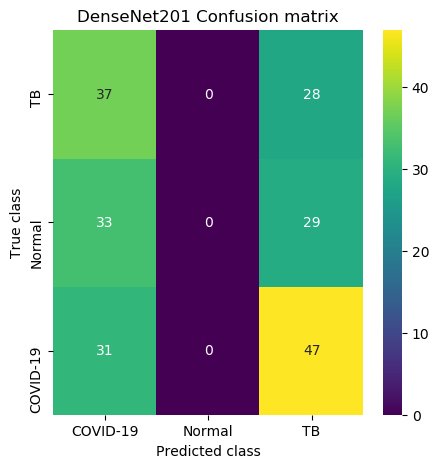

In [7]:
#now training DenseNet201 model
#defining DenseNet object
densenet = DenseNet201(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in densenet.layers:
    layer.trainable = False
densenet_model = Sequential()
densenet_model.add(densenet) #now adding densenet model as transfer learning to retrain model on TB dataset
#defining layer with 32 neurons
densenet_model.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
densenet_model.add(MaxPooling2D(pool_size = (1, 1)))
densenet_model.add(Convolution2D(32, 1, 1, activation = 'relu'))
densenet_model.add(MaxPooling2D(pool_size = (1, 1)))
densenet_model.add(Flatten())
densenet_model.add(Dense(output_dim = 256, activation = 'relu'))
densenet_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
print(densenet_model.summary())
densenet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("models/densenet.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='models/densenet.hdf5', verbose = 1, save_best_only = True)
    hist = densenet_model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('models/densenet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    inception_model = load_model("models/densenet.hdf5")
predict = densenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)   
calculateMetrics("DenseNet201", predict, testY)

c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(80, 80, 3..., activation="relu")`
  if __name__ == "__main__":
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 AP

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 3, 3, 1280)        2257984   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 32)          40992     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 32)          1056      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

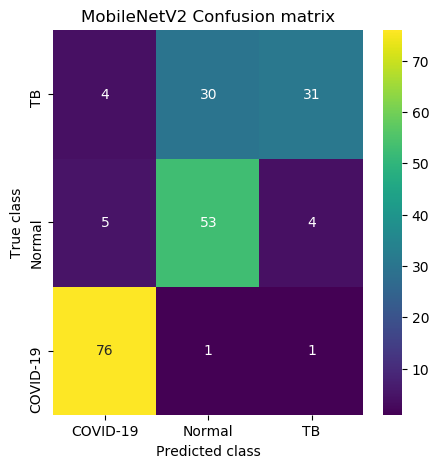

In [8]:
#now training MobilenetV2
#defining mobilenet object
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in mobilenet.layers[:-10]:  # set the last 10 layers to be trainable
    layer.trainable = False
mobilenet_model = Sequential()
mobilenet_model.add(mobilenet) #now adding inception model as transfer learning to retrain model on TB dataset
#defining layer with 32 neurons
mobilenet_model.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
mobilenet_model.add(MaxPooling2D(pool_size = (1, 1)))
mobilenet_model.add(Convolution2D(32, 1, 1, activation = 'relu'))
mobilenet_model.add(MaxPooling2D(pool_size = (1, 1)))
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(output_dim = 256, activation = 'relu'))
mobilenet_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
print(mobilenet_model.summary())
mobilenet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("models/mobilenet.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='models/mobilenet.hdf5', verbose = 1, save_best_only = True)
    hist = mobilenet_model.fit(X_train, y_train, batch_size =32, epochs =25, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('models/mobilenet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    mobilenet_model = load_model("models/mobilenet.hdf5")
predict = mobilenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)   
calculateMetrics("MobileNetV2", predict, testY)

c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(80, 80, 3..., activation="relu")`
  if __name__ == "__main__":
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  from ipykernel import kernelapp as app


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 32)          65568     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 32)          1056      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

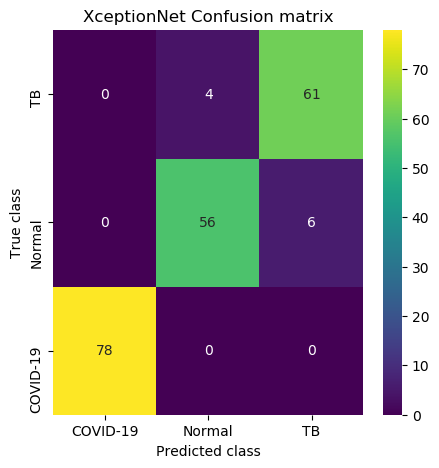

In [9]:
#now training Xception model
#defining Xception object
xception = Xception(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in xception.layers:
    layer.trainable = False
xception_model = Sequential()
xception_model.add(xception) #now adding xception model as transfer learning to retrain model on TB dataset
#defining layer with 32 neurons
xception_model.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
xception_model.add(MaxPooling2D(pool_size = (1, 1)))
xception_model.add(Convolution2D(32, 1, 1, activation = 'relu'))
xception_model.add(MaxPooling2D(pool_size = (1, 1)))
xception_model.add(Flatten())
xception_model.add(Dense(output_dim = 256, activation = 'relu'))
xception_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
print(xception_model.summary())
xception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("models/xception.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='models/xception.hdf5', verbose = 1, save_best_only = True)
    hist = xception_model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('models/xception_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    xception_model = load_model("models/xception.hdf5")
predict = xception_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)   
calculateMetrics("XceptionNet", predict, testY)    

c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  del sys.path[0]
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  from ipykernel import kernelapp as app


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 32)        129056    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 32)        1056      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

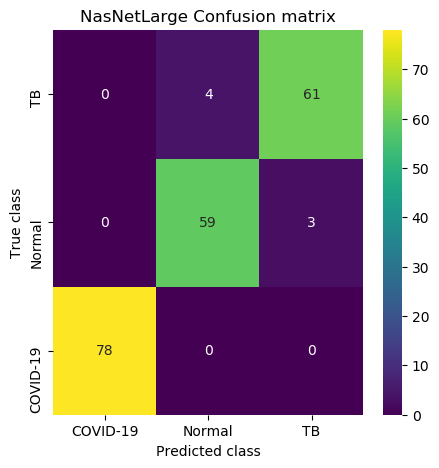

In [10]:
# define NASNetLarge object with modified input shape
nasnet = NASNetLarge(include_top=False, weights='imagenet', input_shape=(331, 331, 3))

# set layers as non-trainable
for layer in nasnet.layers:
    layer.trainable = False

# create a sequential model and add the modified NASNetLarge model as the first layer
nasnet_model = Sequential()
nasnet_model.add(nasnet)

# add additional layers as before
nasnet_model.add(Convolution2D(32, 1, 1, activation='relu'))
nasnet_model.add(MaxPooling2D(pool_size=(1, 1)))
nasnet_model.add(Convolution2D(32, 1, 1, activation='relu'))
nasnet_model.add(MaxPooling2D(pool_size=(1, 1)))
nasnet_model.add(Flatten())
nasnet_model.add(Dense(units=256, activation='relu'))
nasnet_model.add(Dense(units=y_train.shape[1], activation='softmax'))
print(nasnet_model.summary())
# compile the model
nasnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
if os.path.exists("models/nasnet.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='models/nasnet.hdf5', verbose=1, save_best_only=True)
    hist = nasnet_model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('models/nasnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    nasnet_model = load_model("models/nasnet.hdf5")

# make predictions and evaluate the model
predict = nasnet_model.predict(X_test)
predict = np.argmax(predict  , axis=1)
testY = np.argmax(y_test, axis=1)   
calculateMetrics("NasNetLarge", predict, testY)

c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), input_shape=(80, 80, 3..., activation="relu")`
  if __name__ == "__main__":
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  
c:\users\ldeve\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`
  from ipykernel import kernelapp as app


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 1, 1, 32)          49184     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 1, 1, 32)          1056      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

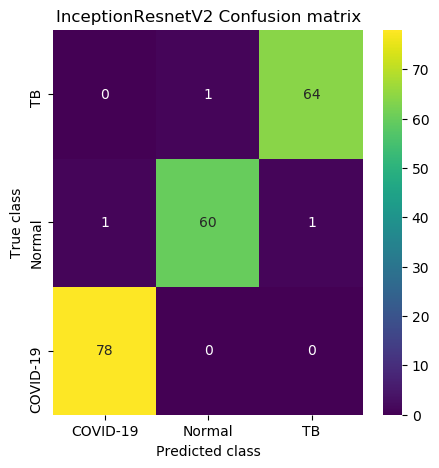

In [11]:
#now training InceptionResnetV2
#defining inception object
inception = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in inception.layers:
    layer.trainable = False
inception_model = Sequential()
inception_model.add(inception) #now adding inception model as transfer learning to retrain model on TB dataset
#defining layer with 32 neurons
inception_model.add(Convolution2D(32, 1, 1, input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
inception_model.add(MaxPooling2D(pool_size = (1, 1)))
inception_model.add(Convolution2D(32, 1, 1, activation = 'relu'))
inception_model.add(MaxPooling2D(pool_size = (1, 1)))
inception_model.add(Flatten())
inception_model.add(Dense(output_dim = 256, activation = 'relu'))
inception_model.add(Dense(output_dim = y_train.shape[1], activation = 'softmax'))
print(inception_model.summary())
inception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("models/inception.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='models/inception.hdf5', verbose = 1, save_best_only = True)
    hist = inception_model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('models/inception_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    inception_model = load_model("models/inception.hdf5")
predict = inception_model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)   
calculateMetrics("InceptionResnetV2", predict, testY)

In [12]:
#extracting inception features
start = timeit.default_timer()
inception_features = Model(inception_model.inputs, inception_model.layers[-3].output)#creating inception model
inception_features = inception_features.predict(X_test)  #extracting inception features from test data
end = timeit.default_timer()
features_extraction_time = end - start
features_time.append(features_extraction_time)
Y = np.argmax(y_test, axis=1) 
print("Extracted InceptionResnetV2 Features Size : "+str(inception_features.shape))
print("InceptionResnetV2 Features Extraction Time : "+str(features_extraction_time))

Extracted InceptionResnetV2 Features Size : (205, 10368)
InceptionResnetV2 Features Extraction Time : 21.617423099999996


In [13]:
#extracting NASNetLarge features
start = timeit.default_timer()
nasnet_features = Model(nasnet_model.inputs, nasnet_model.layers[-2].output)#creating nasnet model
nasnet_features = nasnet_features.predict(X_test)  #extracting xception features from test data
end = timeit.default_timer()
features_extraction_time = end - start
features_time.append(features_extraction_time)
print("Extracted NASNetLarge Features Size : "+str(nasnet_features.shape))
print("NASNetLarge Features Extraction Time : "+str(features_extraction_time))

Extracted NASNetLarge Features Size : (205, 256)
NASNetLarge Features Extraction Time : 22.596092599999793


In [14]:
ensemble_features = np.column_stack((inception_features, nasnet_features)) #now here merging all features as ensemble
print("Ensemble Features Size : "+str(ensemble_features.shape))

Ensemble Features Size : (205, 10624)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(ensemble_features, Y, test_size=0.2) #spliting ensemble features into train and test
print()
print("Ensemble train & test split as 80% dataset for training and 20% for testing")
print("Ensemble Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Ensemble Testing Size (20%): "+str(X_test.shape[0]))
print()


Ensemble train & test split as 80% dataset for training and 20% for testing
Ensemble Training Size (80%): 164
Ensemble Testing Size (20%): 41




SVM Accuracy  : 100.0
SVM Precision   : 100.0
SVM Recall      : 100.0
SVM FMeasure    : 100.0
SVM AUC         : 51.72413793103448


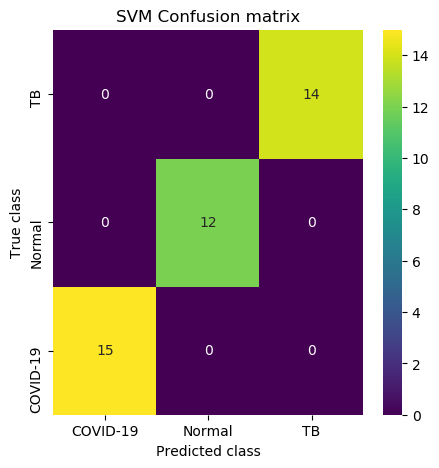

In [16]:
#now training SVM with ensemble features
svm_cls = svm.SVC() 
svm_cls.fit(X_train, y_train)
predict = svm_cls.predict(X_test)
calculateMetrics("SVM", predict, y_test)


KNN Accuracy  : 100.0
KNN Precision   : 100.0
KNN Recall      : 100.0
KNN FMeasure    : 100.0
KNN AUC         : 51.72413793103448


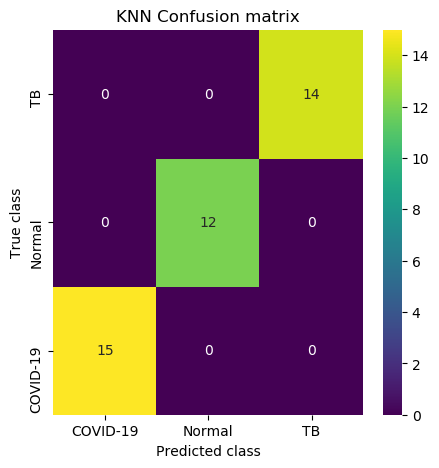

In [17]:
#now training KNN with ensemble features
knn_cls = KNeighborsClassifier() 
knn_cls.fit(X_train, y_train)
predict = knn_cls.predict(X_test)
calculateMetrics("KNN", predict, y_test)


Ensemble Bagging Classifier Accuracy  : 97.5609756097561
Ensemble Bagging Classifier Precision   : 97.91666666666666
Ensemble Bagging Classifier Recall      : 97.61904761904762
Ensemble Bagging Classifier FMeasure    : 97.69016328156113
Ensemble Bagging Classifier AUC         : 55.172413793103445


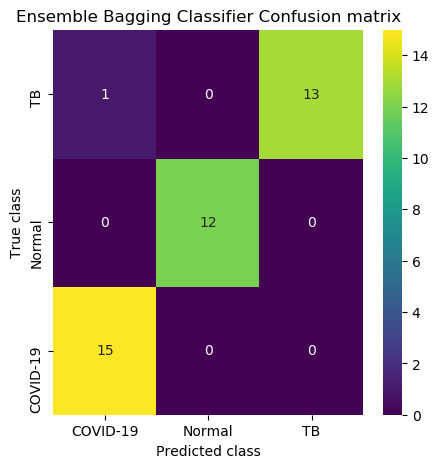

In [18]:
#now training Bagging Classifier with ensemble features
bc_cls = BaggingClassifier()
bc_cls.fit(X_train, y_train)
predict = bc_cls.predict(X_test)
calculateMetrics("Ensemble Bagging Classifier", predict, y_test)


Ensemble Extension Random Forest Classifier Accuracy  : 100.0
Ensemble Extension Random Forest Classifier Precision   : 100.0
Ensemble Extension Random Forest Classifier Recall      : 100.0
Ensemble Extension Random Forest Classifier FMeasure    : 100.0
Ensemble Extension Random Forest Classifier AUC         : 51.72413793103448


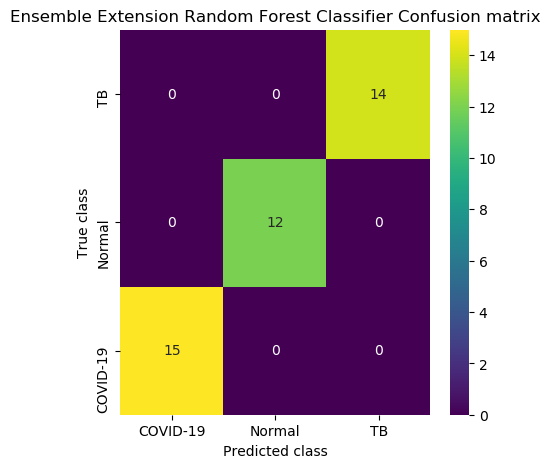

In [19]:
#now training Random Forest Classifier with ensemble features as extension
rf_cls = RandomForestClassifier()
rf_cls.fit(X_train, y_train)
predict = rf_cls.predict(X_test)
calculateMetrics("Ensemble Extension Random Forest Classifier", predict, y_test)


Ensemble Extension XGBoost Classifier Accuracy  : 100.0
Ensemble Extension XGBoost Classifier Precision   : 100.0
Ensemble Extension XGBoost Classifier Recall      : 100.0
Ensemble Extension XGBoost Classifier FMeasure    : 100.0
Ensemble Extension XGBoost Classifier AUC         : 51.72413793103448


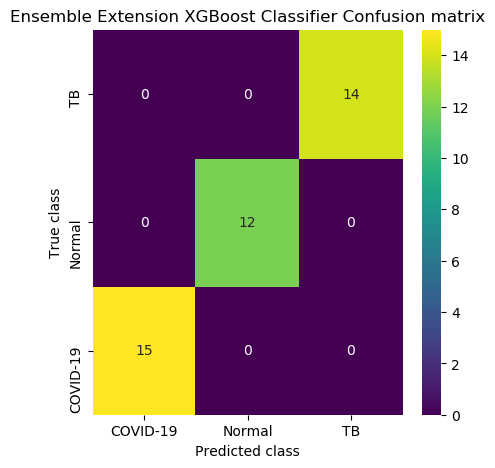

In [20]:
from xgboost import XGBClassifier
#now training XGBOOST with ensemble features as extension
rf_cls = XGBClassifier()
rf_cls.fit(X_train, y_train)
predict = rf_cls.predict(X_test)
acc = accuracy_score(predict, y_test)
calculateMetrics("Ensemble Extension XGBoost Classifier", predict, y_test)

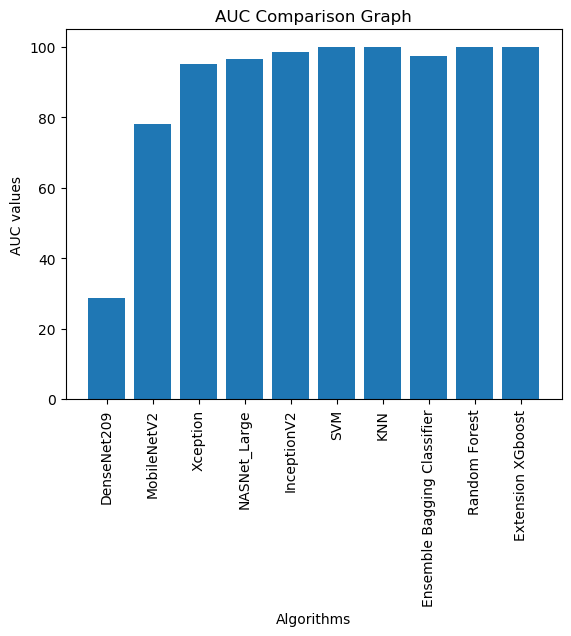

In [21]:
height = accuracy
bars = ( 'DenseNet209', 'MobileNetV2','Xception', 'NASNet_Large', 'InceptionV2','SVM', 'KNN', 'Ensemble Bagging Classifier', 'Random Forest', 'Extension XGboost')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation=90)
plt.xlabel("Algorithms")
plt.ylabel("AUC values")
plt.title("AUC Comparison Graph")
plt.show()


In [22]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy","AUC"]
values = []
algorithm_names = ["DenseNet201","MobileNetV2","Xception","NASNet_Large","InceptionV2","SVM","KNN","Bagging Classifier","Extension Random Forest", "Extension XGBoost"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i],auc[i]])
    
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy,AUC
0,DenseNet201,19.205382,27.606838,22.590989,28.780488,47.163321
1,MobileNetV2,79.539371,76.870692,75.746804,78.048780,65.074442
2,Xception,94.792703,94.722911,94.742507,95.121951,58.143469
3,NASNet_Large,96.321098,96.335815,96.324548,96.585366,57.043763
4,InceptionV2,98.518790,98.411911,98.461857,98.536585,54.816152
5,SVM,100.000000,100.000000,100.000000,100.000000,51.724138
6,KNN,100.000000,100.000000,100.000000,100.000000,51.724138
7,Bagging Classifier,97.916667,97.619048,97.690163,97.560976,55.172414
8,Extension Random Forest,100.000000,100.000000,100.000000,100.000000,51.724138
9,Extension XGBoost,100.000000,100.000000,100.000000,100.000000,51.724138


In [23]:
def predict(test_image, inception_model, true_label):
    labels = ['COVID-19', 'Normal', 'TB']
    image = cv2.imread(test_image)
    img = cv2.resize(image, (80,80))
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,80,80,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255
    preds = inception_model.predict(img)
    predict = np.argmax(preds)
    score = np.amax(preds)
    img = cv2.imread(test_image)
    img = cv2.resize(img, (1000,600)) # increase the image size
    accuracy = round(preds[0][true_label] * 100, 2)
    cv2.putText(img, 'Prediction Output : '+labels[predict]+" Detected. Accuracy: "+str(accuracy)+"%", (10, 50),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2) # increase font size and reposition text
    plt.figure(figsize=(16,12)) # increase the plot size
    plt.imshow(img)


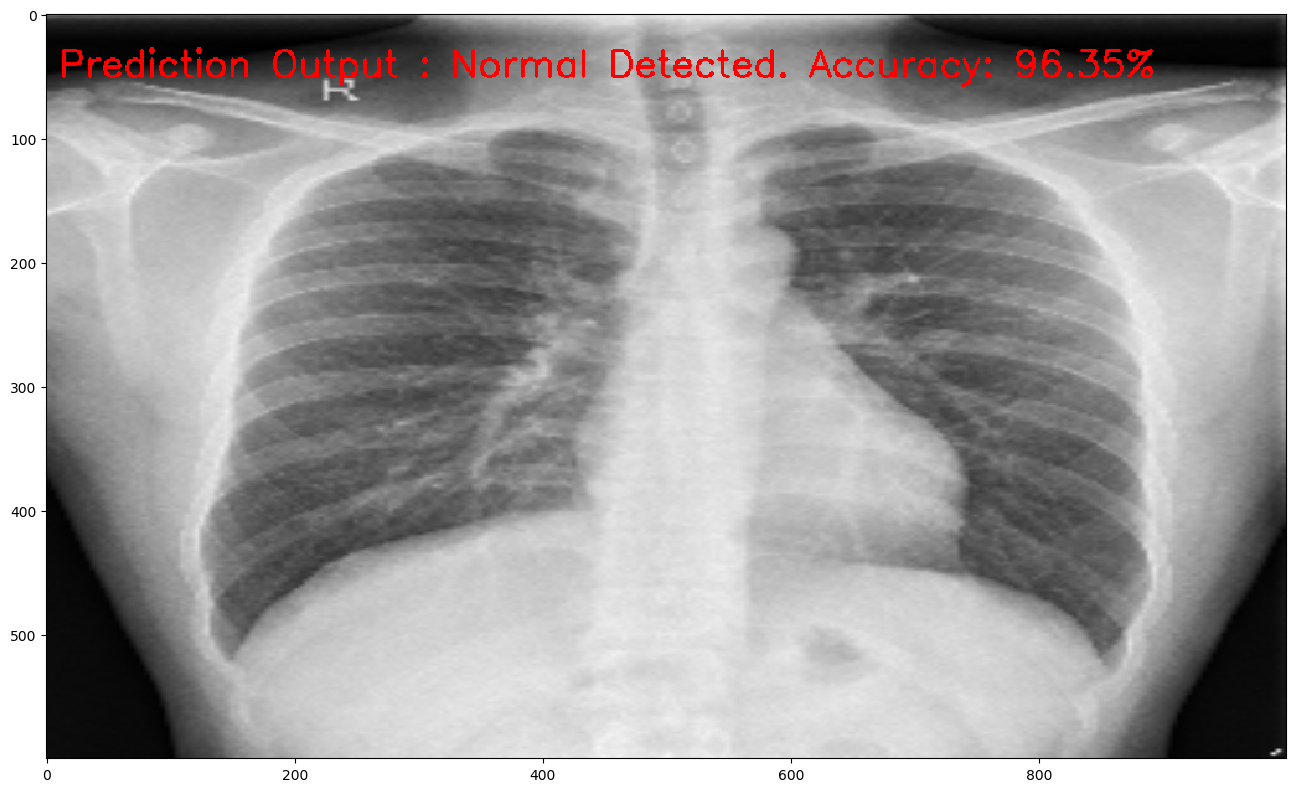

In [24]:
predict("testImages/2.png",inception_model,1)

In [ ]:
predict("testImages/8.png",inception_model,2)

In [ ]:
predict("testImages/01.jpg",inception_model,0)